In [3]:
# 验证码图片生成库安装
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple captcha
# 可视化模型结构图所需库
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple pydot, pydot_ng, graphviz

我们还需要安装一个软件，软件下载网址是：
https://graphviz.gitlab.io/_pages/Download/Download_windows.html

找到对应系统安装即可，记得一定要添加系统变量，若在安装时未勾选添加系统变量，则安装完成后需手动添加。


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAvgPool2D, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import os
from tensorflow.keras.utils import plot_model
from captcha.image import ImageCaptcha
import random
import string
import matplotlib.pyplot as plt

In [6]:
# 字符包含所有数字和所有大小写英文字母，一共 62 个
characters = string.digits + string.ascii_letters
# 类别数 62
num_classes = len(characters)
# 批次大小
batch_size = 128
# 周期数
epochs = 30
# 训练集数据，大约 50000 张图片
train_dir = "./captcha/train/"
# 测试集数据，大约 10000 张图片
test_dir = "./captcha/test/"
# 测试集数据，大约 1000 张图片
val_dir = "./captcha/val/"
# 图片宽度
width = 160
# 图片高度
height = 60

In [7]:
def create_directory_with_subdirectories(directory_path):
    try:
        # 创建主文件夹
        os.makedirs(directory_path, exist_ok=True)
        print(f"主文件夹captcha '{directory_path}' 创建成功或已存在！")

        # 子文件夹1和子文件夹2的路径
        subdirectory1_path = os.path.join(directory_path, "train")
        subdirectory2_path = os.path.join(directory_path, "test")
        subdirectory3_path = os.path.join(directory_path, "val")

        # 检查子文件夹是否存在
        if not os.path.exists(subdirectory1_path):
            os.makedirs(subdirectory1_path)
            print(f"子文件夹train '{subdirectory1_path}' 创建成功！")
        else:
            print(f"子文件夹train '{subdirectory1_path}' 已存在！")

        if not os.path.exists(subdirectory2_path):
            os.makedirs(subdirectory2_path)
            print(f"子文件夹test '{subdirectory2_path}' 创建成功！")
        else:
            print(f"子文件夹test '{subdirectory2_path}' 已存在！")

        if not os.path.exists(subdirectory3_path):
            os.makedirs(subdirectory3_path)
            print(f"子文件夹val '{subdirectory3_path}' 创建成功！")
        else:
            print(f"子文件夹val '{subdirectory2_path}' 已存在！")

    except OSError as error:
        print(f"创建文件夹出错：{error}")


# 调用函数来创建文件夹和子文件夹
main_directory_path = "./captcha"
create_directory_with_subdirectories(main_directory_path)

主文件夹captcha './captcha' 创建成功或已存在！
子文件夹train './captcha/train' 创建成功！
子文件夹test './captcha/test' 创建成功！
子文件夹val './captcha/val' 创建成功！


In [8]:
# 随机产生验证码，长度为 4
def random_captcha_text(char_set=characters, captcha_size=4):
    # 验证码列表
    captcha_text = []
    for _ in range(captcha_size):
        # 随机选择
        c = random.choice(char_set)
        # 加入验证码列表
        captcha_text.append(c)
    return captcha_text


# 生成字符对应的验证码
def gen_captcha_text_and_image(dir):
    # 验证码图片宽高可以设置，默认 width=160, height=60
    image = ImageCaptcha(width=160, height=60)
    # 获得随机生成的验证码
    captcha_text = random_captcha_text()
    # 把验证码列表转为字符串
    captcha_text = ''.join(captcha_text)
    # 保存验证码图片
    image.write(captcha_text, dir + captcha_text + '.jpg')

In [9]:
if_gen_train = True
if_gen_test = True

if if_gen_train:
    # 产生 50000 次随机验证码 真正的数量可能会少于 50000 因为重名的图片会被覆盖掉
    for i in range(50000):
        gen_captcha_text_and_image(train_dir)
    print("训练集生成完毕")

if if_gen_test:
    # 产生 10000 次随机验证码 真正的数量可能会少于 10000 因为重名的图片会被覆盖掉
    for i in range(10000):
        gen_captcha_text_and_image(test_dir)
    print("测试集生成完毕")

for _ in range(1000):
    gen_captcha_text_and_image(val_dir)
print('测试集生成完毕')

训练集生成完毕
测试集生成完毕
测试集生成完毕


In [10]:
# 获取所有验证码图片路径和标签
def get_filenames_and_classes(dataset_dir):
    # 存放图片路径
    photo_filenames = []
    # 存放图片标签
    y = []
    for filename in os.listdir(dataset_dir):
        # 获取文件完整路径
        path = os.path.join(dataset_dir, filename)
        # 保存图片路径
        photo_filenames.append(path)
        # 取文件名前 4 位，也就是验证码的标签
        captcha_text = filename[0:4]
        # 定义一个空 label
        label = np.zeros((4, num_classes), dtype=np.uint8)
        # 标签转独热编码
        for _, ch in enumerate(captcha_text):
            # 设置标签，独热编码 one-hot 格式
            # characters.find(ch)得到 ch 在 characters 中的位置，可以理解为 ch 的编号
            label[_, characters.find(ch)] = 1
            # 保存独热编码的标签
        y.append(label)
    # 返回图片路径和标签
    return np.array(photo_filenames), np.array(y)


# 获取训练集图片路径和标签
x_train, y_train = get_filenames_and_classes(train_dir)
# 获取测试集图片路径和标签
x_test, y_test = get_filenames_and_classes(test_dir)

print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')

x_train.shape:(49913,), y_train.shape:(49913, 4, 62)


In [11]:
# 图像处理函数
# 获得每一条数据的图片路径和标签
def image_function(filenames, label):
    # 根据图片路径读取图片内容
    image = tf.io.read_file(filenames)
    # 将图像解码为 jpeg 格式的 3 维数据
    image = tf.image.decode_jpeg(image, channels=3)
    # 归一化
    image = tf.cast(image, tf.float32) / 255.0
    # 返回图片数据和标签
    return image, label


# 标签处理函数
# 获得每一个批次的图片数据和标签
def label_function(image, label):
    # transpose 改变数据的维度，比如原来的数据 shape 是(batch_size, 4, 62)
    # tf.transpose(label, [1, 0, 2])计算后得到的 shape 为(4, batch_size, 62)
    # 原来的第 1 个维度变成了第 0 维度，原来的第 0 维度变成了 1 维度，第 2 维不变
    label = tf.transpose(label, [1, 0, 2])
    # 返回图片内容和标签，注意这里标签的返回，我们的模型会定义 4 个任务，所以这里返回4个标签
    # 每个标签的 shape 为(batch_size, num_classes)，64 是批次大小，62 是独热编码格式的标签
    return image, (label[0], label[1], label[2], label[3])


In [13]:
# 创建 dataset 对象，传入训练集图片路径和标签
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# reshuffle_each_iteration=True，每次迭代都会随机打乱
dataset_train = dataset_train.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
# map-可以自定义一个函数来处理每一条数据
dataset_train = dataset_train.map(image_function)
# 数据重复生成 1 个周期
dataset_train = dataset_train.repeat(1)
# 定义批次大小
dataset_train = dataset_train.batch(batch_size)
# 注意这个 map 和前面的 map 有所不同，第一个 map 在 batch 之前，所以是处理每一条数据
# 这个 map 在 batch 之后，所以是处理每一个 batch 的数据
dataset_train = dataset_train.map(label_function)
# 创建 dataset 对象，传入测试集图片路径和标签
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# reshuffle_each_iteration=True，每次迭代都会随机打乱
dataset_test = dataset_test.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
# map-可以自定义一个函数来处理每一条数据
dataset_test = dataset_test.map(image_function)
# 数据重复生成 1 个周期
dataset_test = dataset_test.repeat(1)
# 定义批次大小
dataset_test = dataset_test.batch(batch_size)
# 注意这个 map 和前面的 map 有所不同，第一个 map 在 batch 之前，所以是处理每一条数据
# 这个 map 在 batch 之后，所以是处理每一个 batch 的数据
dataset_test = dataset_test.map(label_function)
# 生成一个批次的数据和标签, 可以用于查看数据和标签的情况
x, y = next(iter(dataset_test))
print(f'x.shape:{x.shape}')
print(f'y.shape:{np.array(y).shape}')

x.shape:(128, 60, 160, 3)
y.shape:(4, 128, 62)


94765736/94765736 [==============================] - 1s 0us/step


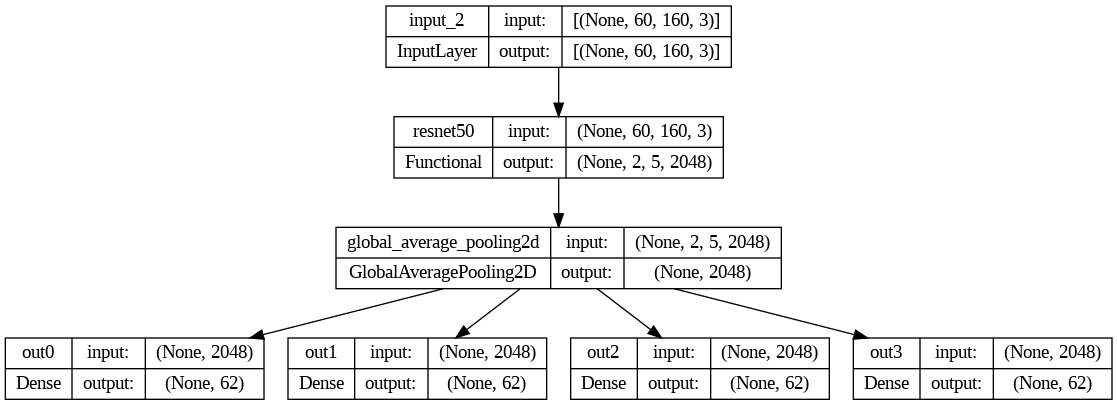

In [14]:
# 载入预训练的 resnet50 模型
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))
# 设置输入
inputs = Input((height, width, 3))
# 使用 resnet50 进行特征提取
x = resnet50(inputs)
# 平均池化
x = GlobalAvgPool2D()(x)
# 把验证码识别的 4 个字符看成是 4 个不同的任务
# 每个任务负责识别 1 个字符
x0 = Dense(num_classes, activation='softmax', name='out0')(x)
x1 = Dense(num_classes, activation='softmax', name='out1')(x)
x2 = Dense(num_classes, activation='softmax', name='out2')(x)
x3 = Dense(num_classes, activation='softmax', name='out3')(x)
# 定义模型
model = Model(inputs, [x0, x1, x2, x3])
# 可视化模型
plot_model(model, to_file='resnet50.png', show_shapes=True)

In [ ]:
# 4 个任务我们可以定义 4 个 loss
# loss_weights 可以用来设置不同任务的权重，验证码识别的 4 个任务权重都一样
model.compile(loss={'out0': 'categorical_crossentropy',
                    'out1': 'categorical_crossentropy',
                    'out2': 'categorical_crossentropy',
                    'out3': 'categorical_crossentropy'},
              loss_weights={'out0': 1,
                            'out1': 1,
                            'out2': 1,
                            'out3': 1},
              optimizer=SGD(learning_rate=1e-2, momentum=0.9),
              metrics=['acc'])

# 监控指标统一使用 val_loss
# 使用 EarlyStopping 来让模型停止，连续 6 个周期 val_loss 没有下降就提前结束训练
# CSVLogger 保存训练数据
# ModelCheckpoint 保存所有训练周期中 val_loss 最低的模型
# ReduceLROnPlateau 学习率调整策略，连续 3 个周期 val_loss 没有下降当前学习率乘以0.1
callbacks = [EarlyStopping(monitor='val_loss', patience=6, verbose=1),
             CSVLogger('Captcha_tfdata.csv'),
             ModelCheckpoint('Best_Captcha_tfdata.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]
# 训练模型
# 把之前定义的 dataset_train 和 dataset_test 传入进行训练
history = model.fit(x=dataset_train,
          epochs=epochs,
          validation_data=dataset_test,
          callbacks=callbacks)

Epoch 1/30
390/390 [==============================] - 206s 413ms/step - loss: 7.0428 - out0_loss: 1.6178 - out1_loss: 1.9870 - out2_loss: 1.9658 - out3_loss: 1.4722 - out0_acc: 0.5670 - out1_acc: 0.4828 - out2_acc: 0.4846 - out3_acc: 0.6052 - val_loss: 24.4671 - val_out0_loss: 5.1346 - val_out1_loss: 5.1664 - val_out2_loss: 6.1831 - val_out3_loss: 7.9830 - val_out0_acc: 0.0205 - val_out1_acc: 0.0155 - val_out2_acc: 0.0170 - val_out3_acc: 0.0162 - lr: 0.0100
Epoch 2/30
390/390 [==============================] - 137s 350ms/step - loss: 0.6549 - out0_loss: 0.1387 - out1_loss: 0.1889 - out2_loss: 0.1962 - out3_loss: 0.1311 - out0_acc: 0.9527 - out1_acc: 0.9383 - out2_acc: 0.9347 - out3_acc: 0.9545 - val_loss: 14.6547 - val_out0_loss: 3.3751 - val_out1_loss: 3.2783 - val_out2_loss: 3.1332 - val_out3_loss: 4.8681 - val_out0_acc: 0.3642 - val_out1_acc: 0.4040 - val_out2_acc: 0.4309 - val_out3_acc: 0.2406 - lr: 0.0100
Epoch 3/30
390/390 [==============================] - 129s 329ms/step - loss

In [16]:
print(history.history.keys())

dict_keys(['loss', 'out0_loss', 'out1_loss', 'out2_loss', 'out3_loss', 'out0_acc', 'out1_acc', 'out2_acc', 'out3_acc', 'val_loss', 'val_out0_loss', 'val_out1_loss', 'val_out2_loss', 'val_out3_loss', 'val_out0_acc', 'val_out1_acc', 'val_out2_acc', 'val_out3_acc', 'lr'])


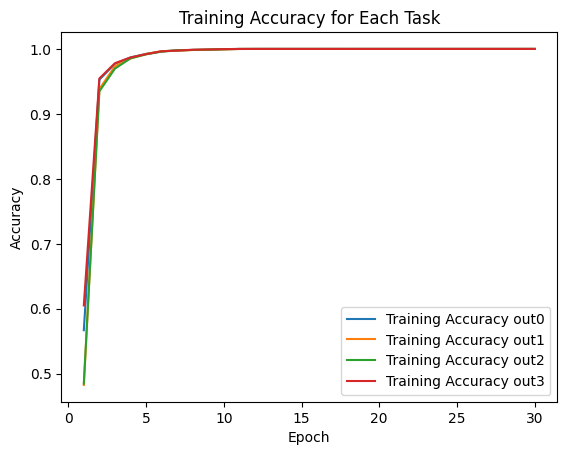

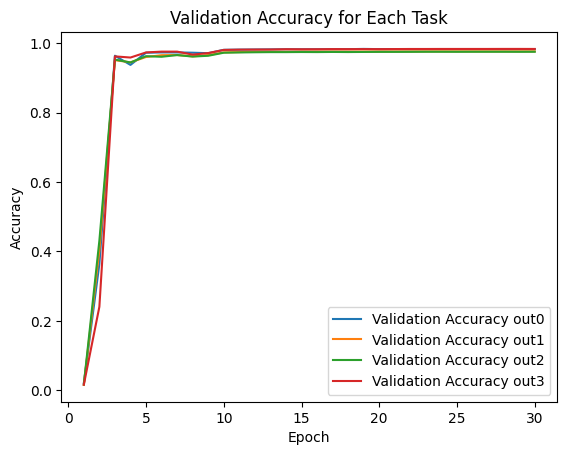

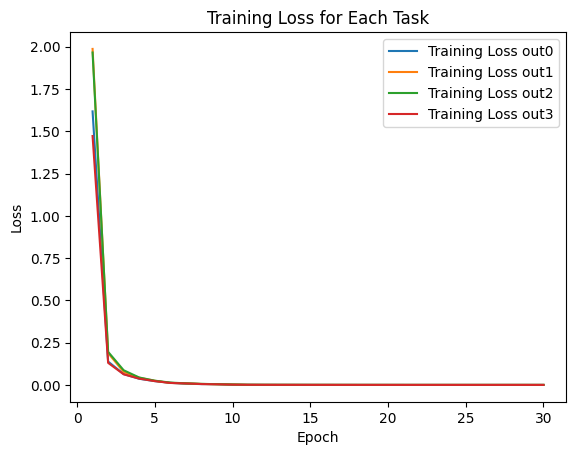

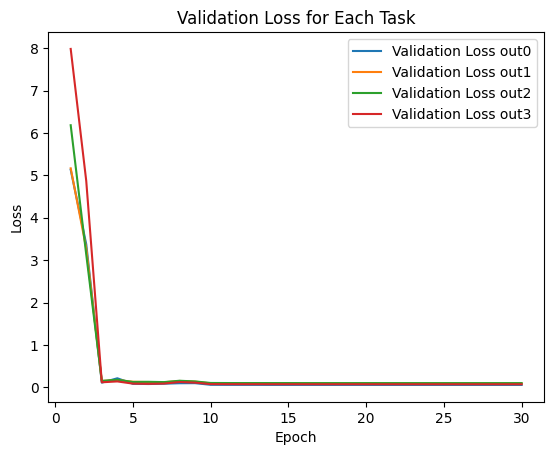

In [18]:
# 获取训练过程中的准确率和损失值
training_accuracy_out0 = history.history['out0_acc']
training_accuracy_out1 = history.history['out1_acc']
training_accuracy_out2 = history.history['out2_acc']
training_accuracy_out3 = history.history['out3_acc']

validation_accuracy_out0 = history.history['val_out0_acc']
validation_accuracy_out1 = history.history['val_out1_acc']
validation_accuracy_out2 = history.history['val_out2_acc']
validation_accuracy_out3 = history.history['val_out3_acc']

training_loss_out0 = history.history['out0_loss']
training_loss_out1 = history.history['out1_loss']
training_loss_out2 = history.history['out2_loss']
training_loss_out3 = history.history['out3_loss']

validation_loss_out0 = history.history['val_out0_loss']
validation_loss_out1 = history.history['val_out1_loss']
validation_loss_out2 = history.history['val_out2_loss']
validation_loss_out3 = history.history['val_out3_loss']

# 创建 epochs 列表，用于横坐标
epochs = range(1, len(training_accuracy_out0) + 1)

# 绘制四个任务在训练集上的准确率曲线
plt.plot(epochs, training_accuracy_out0, label='Training Accuracy out0')
plt.plot(epochs, training_accuracy_out1, label='Training Accuracy out1')
plt.plot(epochs, training_accuracy_out2, label='Training Accuracy out2')
plt.plot(epochs, training_accuracy_out3, label='Training Accuracy out3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy for Each Task')
plt.show()

# 绘制四个任务在测试集上的准确率曲线
plt.plot(epochs, validation_accuracy_out0, label='Validation Accuracy out0')
plt.plot(epochs, validation_accuracy_out1, label='Validation Accuracy out1')
plt.plot(epochs, validation_accuracy_out2, label='Validation Accuracy out2')
plt.plot(epochs, validation_accuracy_out3, label='Validation Accuracy out3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for Each Task')
plt.show()

# 绘制四个任务在训练集上的损失值曲线
plt.plot(epochs, training_loss_out0, label='Training Loss out0')
plt.plot(epochs, training_loss_out1, label='Training Loss out1')
plt.plot(epochs, training_loss_out2, label='Training Loss out2')
plt.plot(epochs, training_loss_out3, label='Training Loss out3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for Each Task')
plt.show()

# 绘制四个任务在测试集上的损失值曲线
plt.plot(epochs, validation_loss_out0, label='Validation Loss out0')
plt.plot(epochs, validation_loss_out1, label='Validation Loss out1')
plt.plot(epochs, validation_loss_out2, label='Validation Loss out2')
plt.plot(epochs, validation_loss_out3, label='Validation Loss out3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss for Each Task')
plt.show()


In [19]:
# 载入之前训练好的模型
model = load_model('Best_Captcha_tfdata.h5')
# 获取测试集图片路径和标签
x_val, y_val = get_filenames_and_classes(val_dir)

# 创建 dataset 对象，传入测试集图片路径和标签
dataset_test = tf.data.Dataset.from_tensor_slices((x_val, y_val))

dataset_test = dataset_test.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
# map-可以自定义一个函数来处理每一条数据
dataset_test = dataset_test.map(image_function)
# 数据重复生成 1 个周期
dataset_test = dataset_test.repeat(1)
# 定义批次大小
dataset_test = dataset_test.batch(batch_size)

dataset_test = dataset_test.map(label_function)

# 用于统计准确率
acc_sum = 0
# 统计批次数量
n = 0
for x, y in dataset_test:
    # 计算批次数量
    n += 1
    # 进行一个批次的预测
    pred = model.predict(x)
    # 获得对应编号
    pred = np.argmax(pred, axis=-1)
    # 获得标签数据
    label = np.argmax(y, axis=-1)
    # 计算这个批次的准确率然后累加到总的准确率统计中
    acc_sum += (pred == label).all(axis=0).mean()
# 计算测试集准确率
print(acc_sum / n)

4/4 [==============================] - 2s 183ms/step
0.9024939903846154


4/4 [==============================] - 0s 36ms/step


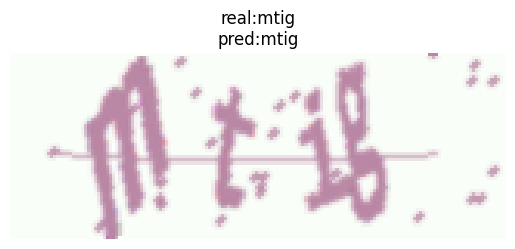

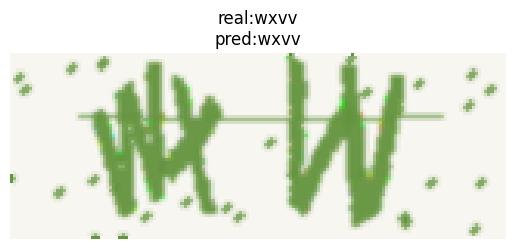

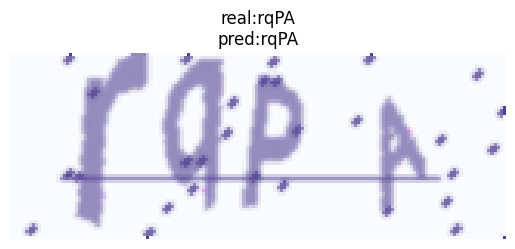

In [20]:
# 把标签编号变成字符串
# 如[2,34,22,45]->'2ymJ'
def labels_to_text(labels):
    ret = []
    for l in labels:
        ret.append(characters[l])
    return "".join(ret)


# 把一个批次的标签编号都变成字符串
def decode_batch(labels):
    ret = []
    for label in labels:
        ret.append(labels_to_text(label))
    return np.array(ret)


# 获得一个批次数据
x, y = next(iter(dataset_test))
# 预测结果
pred = model.predict(x)
# 获得对应编号
pred = np.argmax(pred, axis=-1)
# shape 转换 (4,64)->(64,4)
pred = pred.T
# 获得标签数据
label = np.argmax(y, axis=-1)
# (4,64)->(64,4)
label = label.T
# 根据编号获得对应验证码
pred = decode_batch(pred)
# 根据编号获得对应验证码
label = decode_batch(label)

# 获取前 3 张图片数据
for i, image in enumerate(x[:3]):
    # 显示图片
    plt.imshow(image)
    # 设置标题
    plt.title('real:%s\npred:%s' % (label[i], pred[i]))
    plt.axis('off')
    plt.show()
